In [1]:
import pandas as pd
import openpyxl
import sys
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
def dataClean(data,start_time,end_time, esp_array):
    # Type casting time string to datetime
    data['System_Date_Time'] = pd.to_datetime(data['System_Date_Time'],format="%Y-%m-%d %H:%M:%S",errors='coerce')
    data['Network_Timestamp'] = pd.to_datetime(data['Network_Timestamp'],format="%y/%m/%d,%H:%M:%S",errors='coerce')
    # Segregating the data on device basis that were deployed for testing
    data_dict = {}
    for esp in esp_array:
        data_esp = f"data_{esp}"
        data_dict[data_esp] = data[(data.ESP_Serial_Number == int(esp)) & (data['Network_Timestamp'] >= start_time) & (data['Network_Timestamp'] <= end_time)]
    # print(data_esp)
    return data_dict

In [3]:
def timeGaps(df):
    df_gap = pd.DataFrame(df['Network_Timestamp'])
    df_gap.set_index('Network_Timestamp', inplace=True)
    time_diff = df_gap.index.to_series().diff()
    gaps = time_diff[time_diff > pd.Timedelta(seconds=6)]
    df_gaps = pd.DataFrame({'Timestamp':gaps.index, 'gaps':gaps.values})
    return df_gaps

In [4]:
def continuous_analysis(continuous_var_arr,df):
    # min/max
    aggregated_stats = df[continuous_var_arr].agg(['min', 'max', 'mean', 'median'])
    return aggregated_stats

In [5]:
def plot_all_catogorical(data, category_var, esp):
    num_plots = len(category_var)
    # Number of plots per row
    num_cols = 3
    # Calculate number of rows needed
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    # Flatten the 2D array of axes into 1D
    axes = axes.flatten()
    for i, column in enumerate(category_var):
        label_counts = data[column].value_counts()
        ax = axes[i]
        label_counts.plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title(f'Count of {column}' + '-ESP ' + esp)
        ax.set_xlabel(column)
        ax.set_ylabel('Counts')
        ax.tick_params(axis='x', rotation=45)
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


In [6]:
def accelaration_freq(accx, accy, accz, esp, axs, position, num_bins=10):
    
    # Define the bins for the histogram based on the data range and number of bins
    bins = np.linspace(min(accx.min(), accy.min(), accz.min()), max(accx.max(), accy.max(), accz.max()), num_bins + 1)

    # Calculate the frequency distribution
    freq_accx, _ = np.histogram(accx, bins=bins)
    freq_accy, _ = np.histogram(accy, bins=bins)
    freq_accz, _ = np.histogram(accz, bins=bins)

    # Set the width for the bars
    bar_width = 0.25
    
    # Set the positions for the bars
    r1 = np.arange(len(freq_accx))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # defining the position of graph by using
    # axs[position]

    bars1 = axs[position].bar(r1, freq_accx, color='#115f9a', width=bar_width, edgecolor='#000000', label='accx')
    bars2 = axs[position].bar(r2, freq_accy, color='#76c68f', width=bar_width, edgecolor='#000000', label='accy')
    bars3 = axs[position].bar(r3, freq_accz, color='#d0f400', width=bar_width, edgecolor='#000000', label='accz')
    
    # Add labels on top of each bar
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            axs[position].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

    # Add labels and title
    axs[position].set_xlabel('Value Range')
    axs[position].set_ylabel('Frequency')
    axs[position].set_title('Frequency Grouped Bar Chart for accx, accy, and accz of Device-' + esp)

    # Add the bin labels (midpoints)
    bin_labels = [f'{bins[i]:.2f} - {bins[i+1]:.2f}' for i in range(len(bins)-1)]
    axs[position].set_xticks([r + bar_width for r in range(len(freq_accx))])
    axs[position].set_xticklabels(bin_labels, rotation=45)

    # Add legend
    axs[position].legend()
    
    # incrementing the position in axs
    return position + 1


def accelaration_time(accx, accy, accz, time, esp, axs, position):
    # Shortening the time format
    timestamps_series = pd.Series(time)
    datetime_series = pd.to_datetime(timestamps_series, format='%y/%m/%d,%H:%M:%S')
    time = datetime_series.dt.strftime('%b %d, %H:%M:%S')
    
    # defining the position of graph by using
    # axs[position]

    # Setting bin ticks
    num_bins = 10
    
    # Plot each axis with time
    axs[position].plot(time, accx, label='accx', color='b', linewidth=1)
    axs[position].plot(time, accy, label='accy', color='g', linewidth=1)
    axs[position].plot(time, accz, label='accz', color='r', linewidth=1)
    
    # Bin the time labels
    bin_indices = np.linspace(0, len(time) - 1, num_bins, dtype=int)
    bin_labels = [time.iloc[i] for i in bin_indices]
    axs[position].set_xticks(bin_labels)
    axs[position].set_xticklabels(bin_labels, rotation=45)

    # Add labels and title
    axs[position].set_xlabel('Time')
    axs[position].set_ylabel('Acceleration')
    axs[position].set_title('Time Series of Acceleration Data of Device-' + esp)
    
    # Add legend
    axs[position].legend()

    return position + 1

In [7]:
def gyroscope_freq(gyrox, gyroy, gyroz, esp, axs, position, num_bins=10):
    
    # Define the bins for the histogram based on the data range and number of bins
    bins = np.linspace(min(gyrox.min(), gyroy.min(), gyroz.min()), max(gyrox.max(), gyroy.max(), gyroz.max()), num_bins + 1)

    # Calculate the frequency distribution
    freq_gyrox, _ = np.histogram(gyrox, bins=bins)
    freq_gyroy, _ = np.histogram(gyroy, bins=bins)
    freq_gyroz, _ = np.histogram(gyroz, bins=bins)

    # Set the width for the bars
    bar_width = 0.25
    
    # Set the positions for the bars
    r1 = np.arange(len(freq_gyrox))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # defining the position of graph by using
    # axs[position]

    bars1 = axs[position].bar(r1, freq_gyrox, color='#115f9a', width=bar_width, edgecolor='#000000', label='gyrox')
    bars2 = axs[position].bar(r2, freq_gyroy, color='#76c68f', width=bar_width, edgecolor='#000000', label='gyroy')
    bars3 = axs[position].bar(r3, freq_gyroz, color='#d0f400', width=bar_width, edgecolor='#000000', label='gyroz')

    # Add labels on top of each bar
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            axs[position].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

    # Add labels and title
    axs[position].set_xlabel('Value Range')
    axs[position].set_ylabel('Frequency')
    axs[position].set_title('Frequency Grouped Bar Chart for gyrox, gyroy, and gyroz of Device-' + esp)

    # Add the bin labels (midpoints)
    bin_labels = [f'{bins[i]:.2f} - {bins[i+1]:.2f}' for i in range(len(bins)-1)]
    axs[position].set_xticks([r + bar_width for r in range(len(freq_gyrox))])
    axs[position].set_xticklabels(bin_labels, rotation=45)
    
    # Setting plots
    axs[position].legend()

    # incrementing the position in axs
    return position + 1

def gyroscope_time(gyrox, gyroy, gyroz, time, esp, axs, position):
    # Shortening the time format
    timestamps_series = pd.Series(time)
    datetime_series = pd.to_datetime(timestamps_series, format='%y/%m/%d,%H:%M:%S')
    time = datetime_series.dt.strftime('%b %d, %H:%M:%S')
    
    # defining the position of graph by using
    # axs[position]

    # Setting bin ticks
    num_bins = 10
    
    # Plot each axis with time
    axs[position].plot(time, gyrox, label='gyrox', color='b', linewidth=1)
    axs[position].plot(time, gyroy, label='gyroy', color='g', linewidth=1)
    axs[position].plot(time, gyroz, label='gyroz', color='r', linewidth=1)
    
    # Bin the time labels
    bin_indices = np.linspace(0, len(time) - 1, num_bins, dtype=int)
    bin_labels = [time.iloc[i] for i in bin_indices]
    axs[position].set_xticks(bin_labels)
    axs[position].set_xticklabels(bin_labels, rotation=45)

    # Add labels and title
    axs[position].set_xlabel('Time')
    axs[position].set_ylabel('Gyroscope')
    axs[position].set_title('Time Series of Gyroscope Data of Device-' + esp)
    
    # Setting plots
    axs[position].legend()

    # incrementing the position in axs
    return position + 1

In [8]:
def temperature_freq(body_T, ideal_T, esp, axs, position, num_bins=10):
    # Define the bins for the histogram based on the data range and number of bins
    bins = np.linspace(min(body_T.min(), ideal_T.min()), max(body_T.max(), ideal_T.max()), num_bins + 1)

    # Calculate the frequency distribution
    freq_body_T, _ = np.histogram(body_T, bins=bins)
    freq_ideal_T, _ = np.histogram(ideal_T, bins=bins)

    # Set the width for the bars
    bar_width = 0.25
    
    # Set the positions for the bars
    r1 = np.arange(len(freq_body_T))
    r2 = [x + bar_width for x in r1]

    # defining the position of graph
    # axs[position]

    bars1 = axs[position].bar(r1, freq_body_T, color='#115f9a', width=bar_width, edgecolor='#000000', label='Body Temp')
    bars2 = axs[position].bar(r2, freq_ideal_T, color='#d0f400', width=bar_width, edgecolor='#000000', label='Ideal Temp')

    # Add labels on top of each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            axs[position].text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

    # Add labels and title
    axs[position].set_xlabel('Value Range')
    axs[position].set_ylabel('Frequency')
    axs[position].set_title('Frequency Grouped Bar Chart for Body_temp, Ideal_temp of Device-' + esp)

    # Add the bin labels (midpoints)
    bin_labels = [f'{bins[i]:.2f} - {bins[i+1]:.2f}' for i in range(len(bins)-1)]
    axs[position].set_xticks([r + bar_width for r in range(len(freq_body_T))])
    axs[position].set_xticklabels(bin_labels, rotation=45)

    # Add legend
    axs[position].legend()

    # incrementing the position in axs
    return position+1


def temperature_time(body_T, ideal_T, time, esp, axs, position):
    # Shortening the time format
    time = pd.Series(time)
    time = pd.to_datetime(time, format='%y/%m/%d,%H:%M:%S')
    time = time.dt.strftime('%b %d, %H:%M:%S')
    
    # defining the position of graph
    # axs[position]

    # Setting bin ticks
    num_bins = 10
    
    # Plot each axis with time
    axs[position].plot(time, body_T, label='Body Temperature', color='b', linewidth=1)
    axs[position].plot(time, ideal_T, label='Ideal Temperature', color='g', linewidth=1)
    
    # Bin the time labels
    bin_indices = np.linspace(0, len(time) - 1, num_bins, dtype=int)
    bin_labels = [time.iloc[i] for i in bin_indices]
    axs[position].set_xticks(bin_labels)
    axs[position].set_xticklabels(bin_labels, rotation=45)

    # Add labels and title
    axs[position].set_xlabel('Time')
    axs[position].set_ylabel('Temperature')
    axs[position].set_title('Time Series of Temperature Data of Device-' + esp)
    
    # Add legend
    axs[position].legend()

    # incrementing the position in axs
    return position+1

In [9]:
def customRange(start, stop, step):
    # -2.32 2.23 0.455
    if step == 0:
        return None
    arr_range = [start]
    arr_label = [f"{round(start, 2)}-{round(start+step, 2)}"]
    while start+step <= stop:
        # print("hi", start)
        start = start + step
        label = f"{round(start, 2)}-{round(start+step, 2)}"
        arr_label.append(label)
        arr_range.append(round(start, 2))
    arr_label.pop()
    return arr_range, arr_label

def others_freq(data, columns, esp, axs, position):

    # defining the position of graph
    # axs[position]
    # print(columns)
    for column in columns:
        max_val = data[column].max()
        min_val = data[column].min()
        bins = customRange(min_val, max_val, round((max_val - min_val) / 10, 3))
        # print(column)
        if bins is None:
            print(f"min == max, in column '{column}', value = {min_val}")
            continue
        
        df = pd.DataFrame()
        df['Bt_binned'] = pd.cut(data[column], bins=bins[0], labels=bins[1], include_lowest=True)
        frequency = df['Bt_binned'].value_counts().sort_index()

        frequency.plot(kind='bar', color='skyblue', ax=axs[position])
        axs[position].set_title('Frequency of ' + column + ' of Device-' + esp)
        axs[position].set_xlabel(column)
        axs[position].set_ylabel('Frequency')
        axs[position].tick_params(axis='x', rotation=45)
        
        axs[position].legend() # creating legend
        # incrementing the position in axs
        position += 1  # Move to the next subplot

    return position

def others_time(data, time, columns, esp, axs, position):
    # Convert time to datetime
    time = pd.to_datetime(time, format='%y/%m/%d,%H:%M:%S')
    time = time.dt.strftime('%b %d, %H:%M:%S')

    # defining the position of graph
    # axs[position]

    
    for column in columns:
        
        # Plotting the time series data using the original datetime series
        axs[position].plot(time, data[column], label=column, linewidth=2)
        axs[position].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=10, maxticks=10))
        
        axs[position].set_title(f'Time Series of {column}' +  ' of Device-' + esp)
        axs[position].set_xlabel('Time')
        axs[position].set_ylabel(column)
        axs[position].tick_params(axis='x', rotation=45)
        
        # Add a legend to the subplot
        axs[position].legend()
        
        position += 1  # Move to the next subplot

    # Return the figure
    return position

In [10]:
def plot_frequency_grouped_bar_chart(data, continuous_col, esp):
    
# FONTS Changed GLOBALLY
###################################################
    # changing font type for this function
    original_params = plt.rcParams.copy() # Save current rcParams
    plt.rcParams.update({'font.size': 16}) # Temporarily change font size
###################################################
    
    # creating the subplots
    row_num = (len(continuous_col)-4)//2
    col_num = 2
    fig, axs = plt.subplots(row_num, col_num, figsize=(35, 17))
    ax_flat = axs.ravel()
    position = 0
    
    # Acc XYZ
    accx = data['accX']
    accy = data['accY']
    accz = data['accZ']
    position = accelaration_freq(accx, accy, accz, esp, ax_flat, position)
    
    # Gyro XYZ
    gyrox = data['gyroX']
    gyroy = data['gyroY']
    gyroz = data['gyroZ']
    position = gyroscope_freq(gyrox, gyroy, gyroz, esp, ax_flat, position)
    
    # Body_Temperature, AT_Ideal_Temperature
    body_T = data['Body_Temperature']
    ideal_T = data['AT_Ideal_Temperature']
    position = temperature_freq(body_T, ideal_T, esp, ax_flat, position)
    
    # Other Graphs
    columns = []
    for i in continuous_col:
        if (i != "accX") & (i != "accY") & (i != "accZ") & (i != "gyroX") & (i != "gyroY") & (i != "gyroZ") & (i != "Body_Temperature") & (i != "AT_Ideal_Temperature"):
            columns.append(i)
    
    position = others_freq(data, columns, esp, ax_flat, position)


# FONTS REVERTED
###################################################
    # Reset to original rcParams after plotting
    plt.rcParams.update(original_params)
###################################################

    # Hide any unused subplots
    for j in range(position, len(ax_flat)):
        fig.delaxes(ax_flat[j])
    
    plt.tight_layout()
    plt.show()


def plot_time_chart(data, continuous_col, esp):
    
# FONTS Changed GLOBALLY
###################################################
    # changing font type for this function
    original_params = plt.rcParams.copy() # Save current rcParams
    plt.rcParams.update({'font.size': 16}) # Temporarily change font size
###################################################
    
    # creating the subplots
    row_num = (len(continuous_col)-4)//2
    col_num = 2
    fig, axs = plt.subplots(row_num, col_num, figsize=(35, 17))
    ax_flat = axs.ravel()
    position = 0
    
    # Time
    time = data['Network_Timestamp']
    
    # Acc XYZ
    accx = data['accX']
    accy = data['accY']
    accz = data['accZ']
    position = accelaration_time(accx, accy, accz, time, esp, ax_flat, position)
    
    # Gyro XYZ
    gyrox = data['gyroX']
    gyroy = data['gyroY']
    gyroz = data['gyroZ']
    position = gyroscope_time(gyrox, gyroy, gyroz, time, esp, ax_flat, position)
    
    # Body_Temperature, AT_Ideal_Temperature
    body_T = data['Body_Temperature']
    ideal_T = data['AT_Ideal_Temperature']
    position = temperature_time(body_T, ideal_T, time, esp, ax_flat, position)

    # Other Graphs
    columns = []
    for i in continuous_col:
        if (i != "accX") & (i != "accY") & (i != "accZ") & (i != "gyroX") & (i != "gyroY") & (i != "gyroZ") & (i != "Body_Temperature") & (i != "AT_Ideal_Temperature"):
            columns.append(i)

    position = others_time(data, time, columns, esp, ax_flat, position)    
    
    
# FONTS REVERTED
###################################################
    # Reset to original rcParams after plotting
    plt.rcParams.update(original_params)
###################################################
    
    # Hide any unused subplots
    for j in range(position, len(ax_flat)):
        fig.delaxes(ax_flat[j])
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

In [11]:
def main():
    # Set file path to extract data
    full_data = pd.read_csv(r"C:\Users\ashve\OneDrive\Desktop\Office_files\Code\Activity_monitor\Field Data\Cleaned_esp_10,11 - Cleaned_esp_10,11.csv")
    # Set esp that were deployed
    esp_array = ['15269688']
    # Set start and end time
    start_time = '2024-09-10 14:40:00'
    end_time = '2024-09-11 20:05:46'
    # Set continuous and category variables that you want to analyse
    continuous_var = ['Body_Temperature','Heart_Rate','SpO2','accX','accY','accZ','gyroX','gyroY','gyroZ','AT_Ideal_Temperature','Battery']
    category_var = ['Body_Activity','Jaw_Movement','Device_Status']
    # Set file path that will receive the data analysis
    file_path = r"C:\Users\ashve\OneDrive\Desktop\Office_files\Code\Activity_monitor\Field Data\Data.xlsx"
    try:
    # Try to load the workbook
        openpyxl.load_workbook(file_path)
    except (FileNotFoundError, openpyxl.utils.exceptions.InvalidFileException):
    # If the file doesn't exist or is invalid, create a new one
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='w') as writer:
        # Add a default sheet to avoid the "no visible sheet" issue
            pd.DataFrame().to_excel(writer, sheet_name='Default')

    dataframes = dataClean(full_data, start_time, end_time, esp_array)
    # print(dataframes)
    
    # Implementing a for loop to analyze data and write it into excel for each device
    for key in dataframes:
        dataframes[key] = dataframes[key].drop(['Unnamed: 0'],axis=1)
        dataframes[key].set_index('SrNo',inplace=True)
        # print(dataframes[key].columns)
        # sys.exit(0)
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
            dataframes[key].to_excel(writer, sheet_name='OG_' + key,startrow=3,startcol=0,index=True)
        time_gap = timeGaps(dataframes[key])
        time_gap["gaps"] = time_gap["gaps"].astype(str)
        cont_analysis = continuous_analysis(continuous_var, dataframes[key])
        cont_analysis = cont_analysis.reset_index() # takes index (min, max, mean, median) and make it a seperate column
        cont_analysis = cont_analysis.rename(columns={'index': ''})
        combined_analysis = pd.concat([time_gap,cont_analysis],axis=1)
        with pd.ExcelWriter(file_path, engine='openpyxl', mode='r+') as writer:
            combined_analysis.to_excel(writer, sheet_name=key,startrow=4,startcol=-0)
        # Graphs
        plot_all_catogorical(dataframes[key],category_var,key)
        plot_frequency_grouped_bar_chart(dataframes[key], continuous_var, key)
        plot_time_chart(dataframes[key], continuous_var, key)
        # plot_all_continuous(dataframes[key],continuous_var,key)


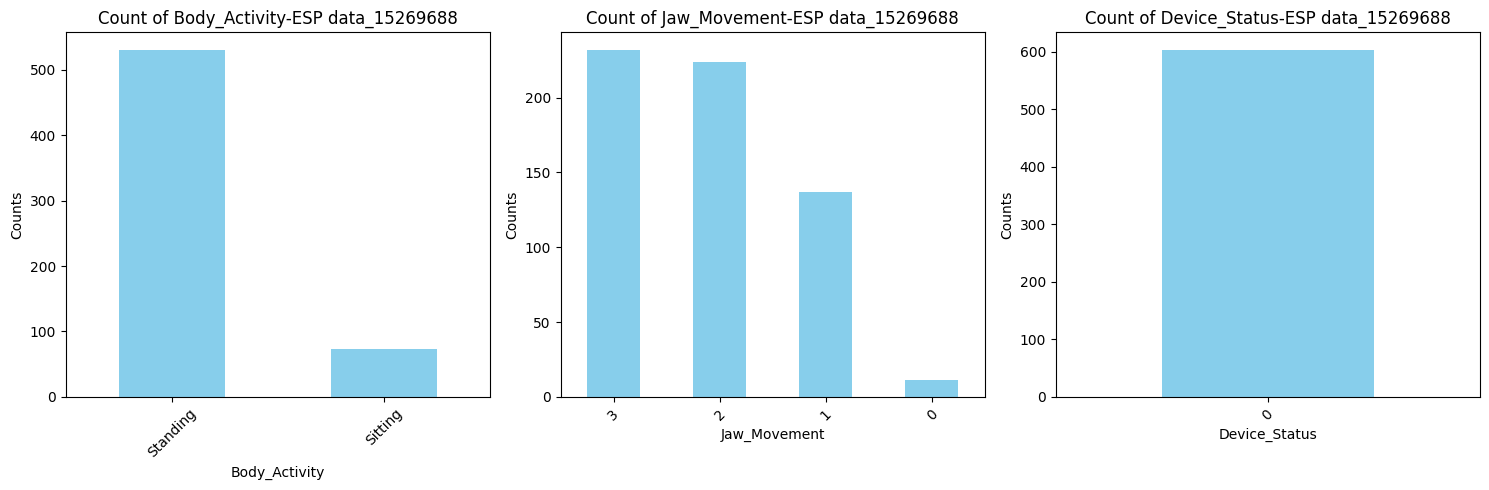

min == max, in column 'Battery', value = 100


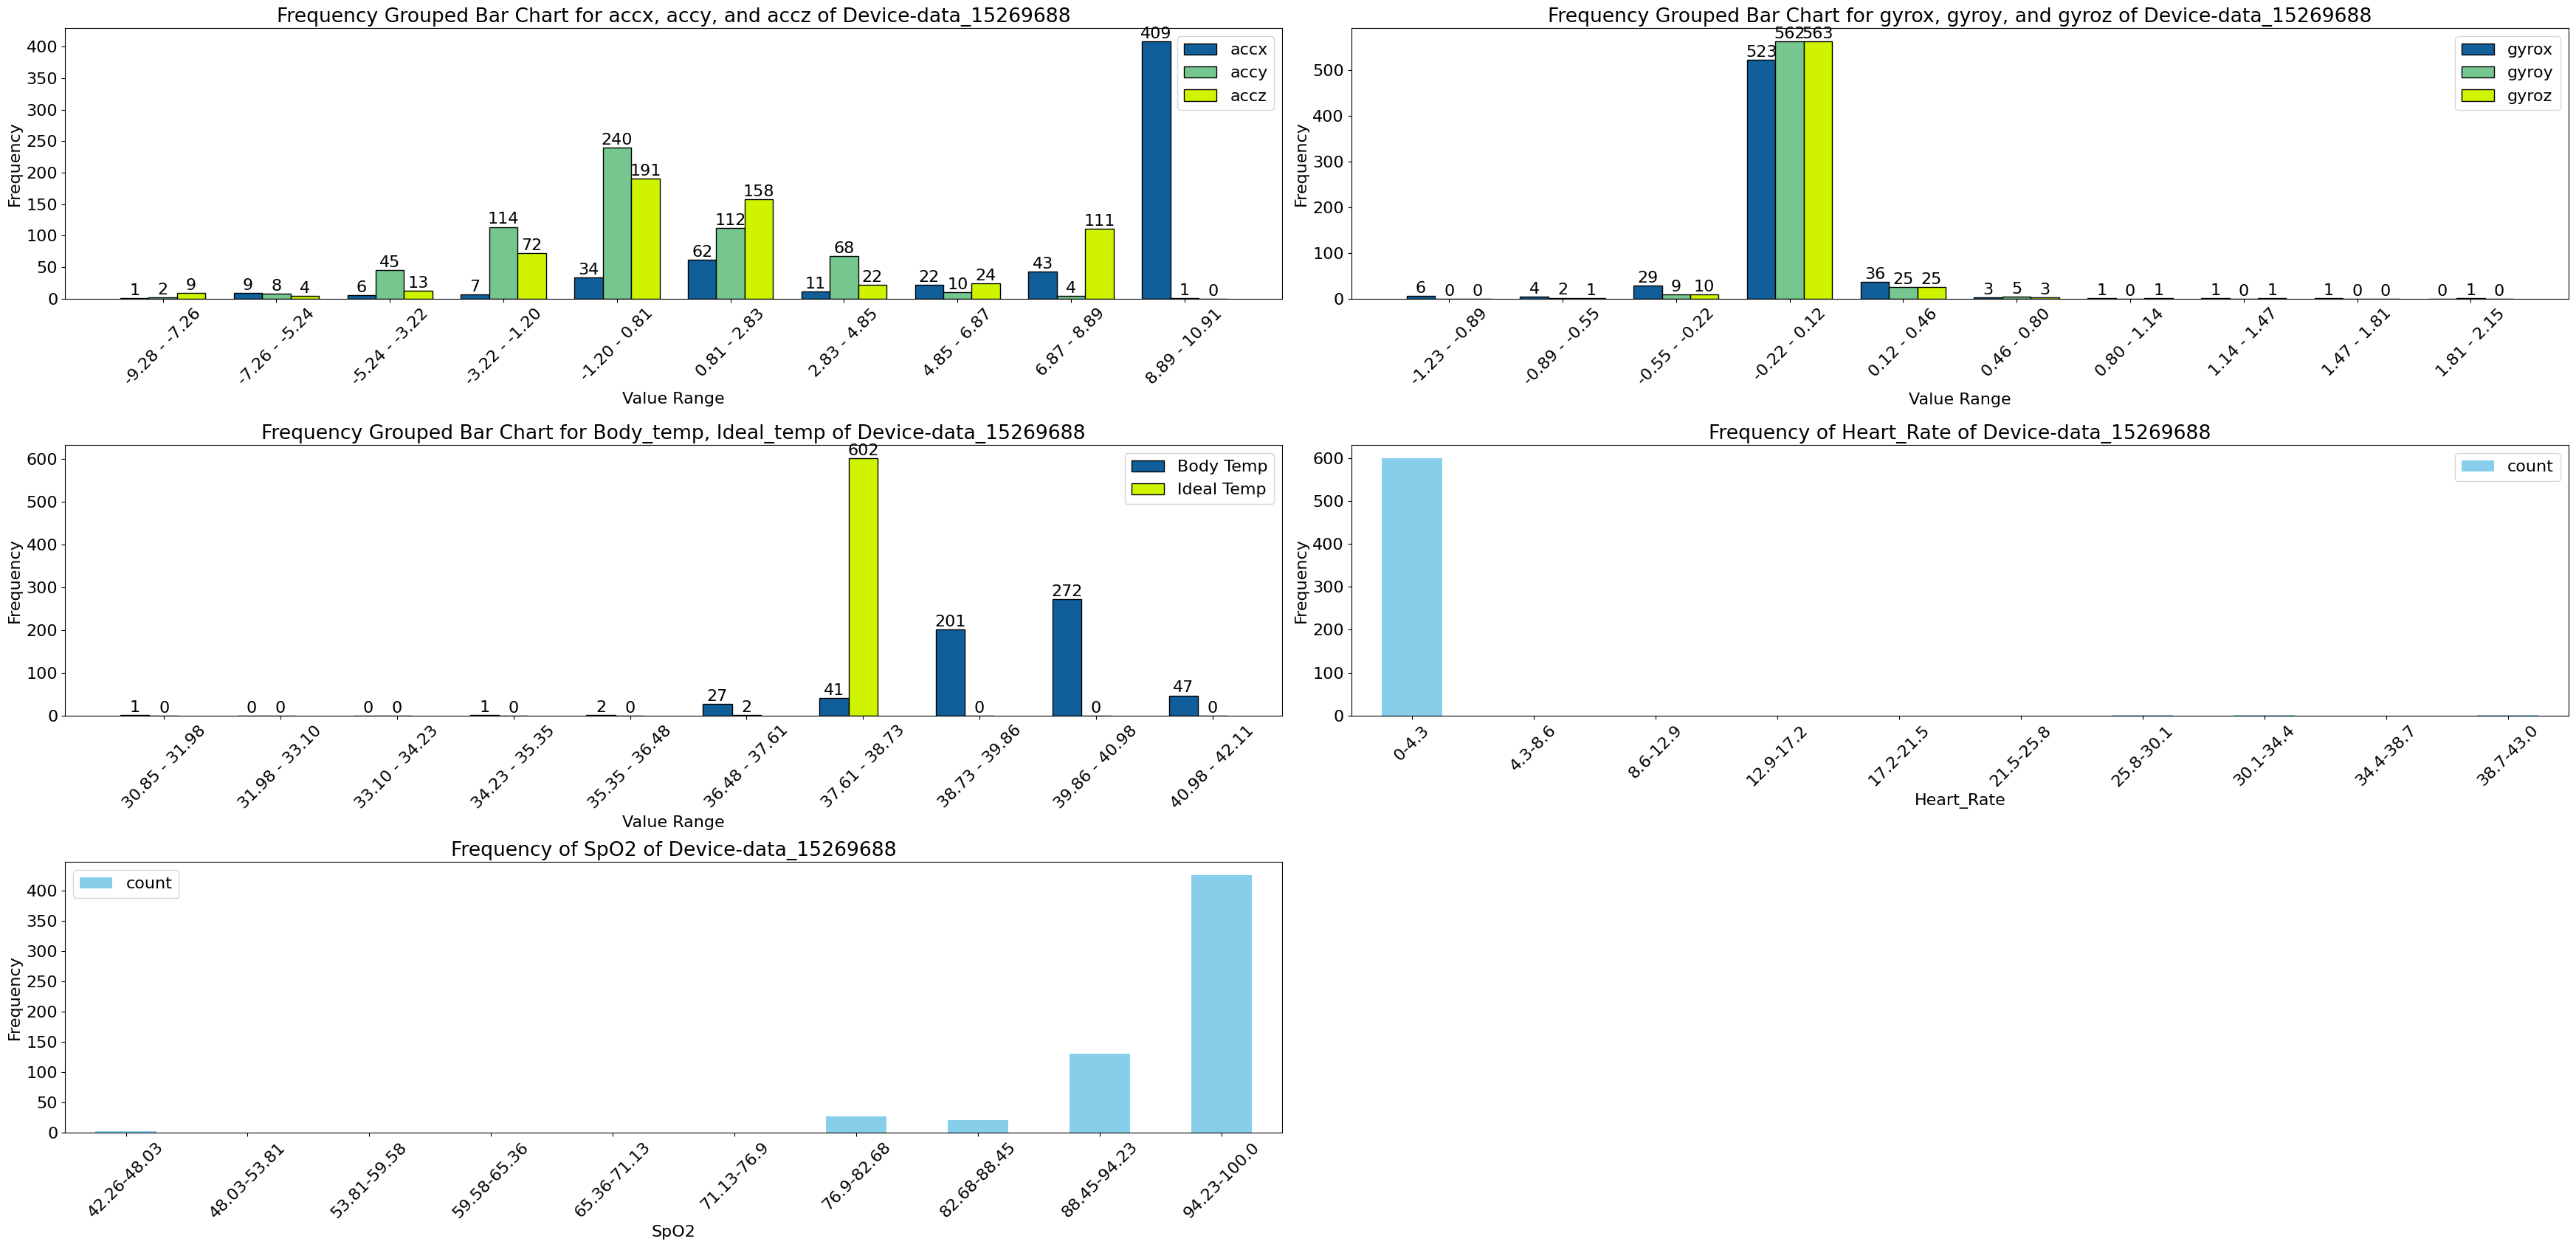

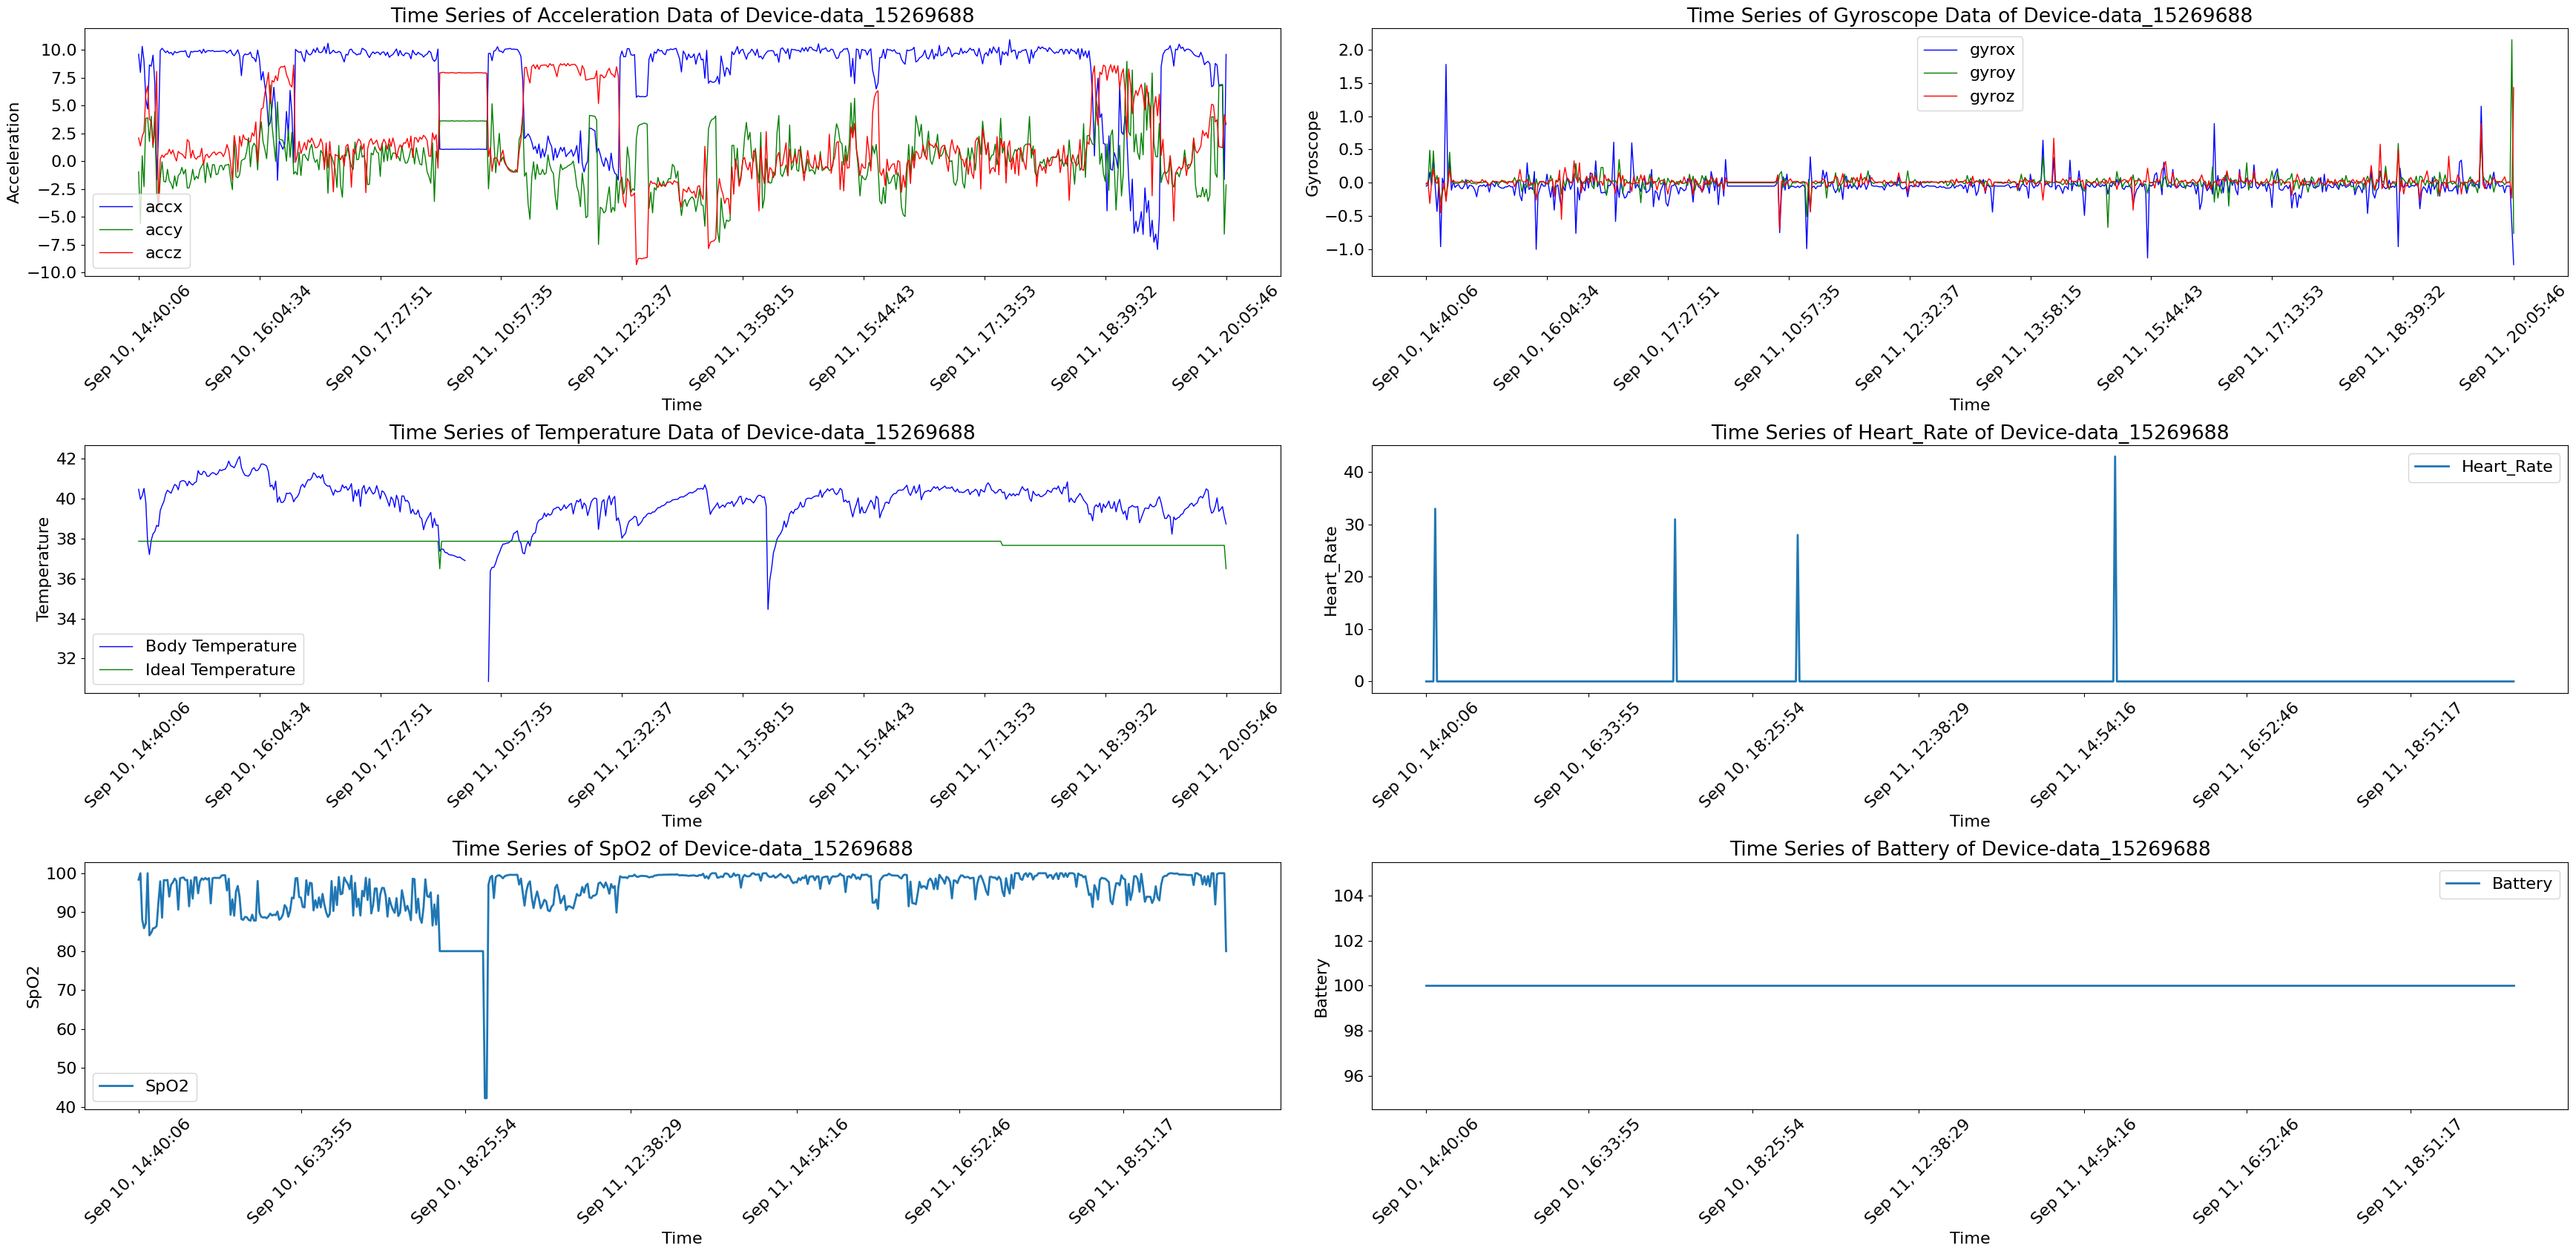

In [12]:
if __name__ == '__main__':
    main()